# TIMC PubMed Searching



Extract the article metadata such as article title, journal name, publication date, from the XML file using the ElementTree library.

Store the extracted information in a pandas dataframe for easier manipulation and analysis.

Clean the data by removing any unnecessary characters, such as HTML tags or special characters.

Check for missing data and decide whether to drop or impute missing values.

Explore the data by visualizing the distribution of article topics, authors, publication dates, etc.

Use natural language processing techniques to extract keywords, topics, or sentiment from the article abstracts.

Use statistical techniques such as regression or clustering to identify patterns or relationships between the variables in the dataset.

Evaluate the quality of the data by comparing it with TIMC findings


filter for these two journals:
    
Antonie van Leeuwenhoek | 
International Journal of Systematic and Evolutionary Microbiology

In [28]:
#allows for multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import Counter

In [16]:
df = pd.read_csv("output500.csv")
df.info()
df.head()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Journal Name         1956 non-null   object 
 1   Year of Publication  1852 non-null   float64
 2   PubMedID             1956 non-null   int64  
 3   Title                1956 non-null   object 
 4   Abstract             1955 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 76.5+ KB


,Journal Name,Year of Publication,PubMedID,Title,Abstract
0,Antonie van Leeuwenhoek,2019.0,31147966,"Ottowia flava sp. nov., isolated from fish int...","A novel Gram-negative bacterium, non-motile an..."
1,Antonie van Leeuwenhoek,2019.0,31147967,Bioinformatic analyses of a potential Salmonel...,"Foodborne Enterobacteriaceae pathogens, especi..."
2,Antonie van Leeuwenhoek,2019.0,31165292,"Hymenobacter oligotrophus sp. nov., isolated f...","A taxonomic study of a Gram-stain negative, ro..."
3,Antonie van Leeuwenhoek,2019.0,31172329,"Flavisolibacter galbus sp. nov., isolated from...","A Gram-stain negative, non-motile, and yellow-..."
4,Antonie van Leeuwenhoek,2019.0,31172330,"Vibrio profundi sp. nov., isolated from a deep...","A Gram-stain negative, rod-shaped, facultative..."


,Journal Name,Year of Publication,PubMedID,Title,Abstract
1951,Antonie van Leeuwenhoek,2012.0,22711299,Molecular signatures for the phylum Synergiste...,Species belonging to the phylum Synergistetes ...
1952,Antonie van Leeuwenhoek,2012.0,22718122,Structured morphological modeling as a framewo...,Successful application of a computational mode...
1953,Antonie van Leeuwenhoek,2012.0,22733059,Saccharomyces bacillaris is not a synonym of C...,Torulopsis bacillaris (Kroemer and Krumbholz) ...
1954,Antonie van Leeuwenhoek,2012.0,22733060,Extracellular sugar phosphates are assimilated...,Filamentous microorganisms of the bacterial ge...
1955,Antonie van Leeuwenhoek,2012.0,22733061,"Pseudonocardia nantongensis sp. nov., a novel ...","A novel isolate, designated strain KLBMP 1282(..."


In [17]:
quinones = {
    "q": [
        "quinone",
        "{},{}-benzoquinone",
        "{},{}-dimethyl-{},{}-benzoquinone",
        "{}-methyl-{},{}-naphthoquinone",
        "{},{}-dimethoxy-{},{}-naphthoquinone",
        "{},{},{},{}-tetramethyl-{},{}-benzoquinone",
        "benzoquinone",
        "naphthoquinone",
        "anthraquinone",
        "phenanthraquinone",
        "azaquinone",
        "aza-anthraquinone",
        "oxoquinone",
        "thioquinone",
    ],
    "uq": [
        "ubiquinone",
        "coenzyme Q",
        "coQ",
        "UQ",
        "Ubiquinone{}",
        "Coenzyme Q{}",
        "CoQ{}",
        "Q{}",
    ],
    "uq-{}": [
        "UQ{}",
        "UQ{}H{}",
        "UQ{}H{}",
        "ubiquinone-{}",
        "ubiquinone-{}(H{})",
        "ubiquinone-{}(H{})",
        "Ubiquinone-{}",
        "Ubiquinone-{}(H{})",
        "Ubiquinone-{}(H{})",
    ],
    "mk": [
        "menaquinone",
        "vitamin K2",
        "MK",
        "Menaquinone",
        "Vitamin K2",
    ],
    "mk-{}": [
        "MK{}",
        "MK{}H{}",
        "MK{}H{}",
        "menaquinone-{}",
        "menaquinone-{}(H{})",
        "menaquinone-{}(H{})",
        "Menaquinone-{}",
        "Menaquinone-{}(H{})",
        "Menaquinone-{}(H{})",
    ],
    "pq": [
        "plastoquinone",
        "PQ",
        "Plastoquinone",
    ],
    "rhq": [
        "rhodoquinone",
        "RQ",
        "Rhodoquinone",
    ],
    "caldq": [
        "Caldariella quinone",
        "CQ",
        "Caldariella Quinone",
    ],
    "dmk": [
        "demethyl-menaquinone",
        "DMK",
        "Demethyl-menaquinone",
    ],
    "mmk": [
        "methyl-menaquinone",
        "MMK",
        "Methyl-menaquinone",
    ],
    "{}-mmk": [
        "{}-methyl-menaquinone",
        "{}-MMK",
        "{}-methyl-Menaquinone",
    ],
    "{},{}-dmmk": [
        "{},{}-dimethyl-menaquinone",
        "{},{}-DMMK",
        "{},{}-Dimethyl-menaquinone",
    ],
}


In [19]:
import re
from nltk.tokenize import sent_tokenize

def find_keyword_sentence(text, keyword):
    for sentence in sent_tokenize(text):
        if keyword in sentence:
            return sentence.strip()
    return ""

def process_row(row):
    genus_species_pattern = r"([A-Z][a-z]+) ([a-z]+(?:-[a-z]+)?)"
    matches = {}
    keyword_sentences = []

    for k, v in quinones.items():
        for term in v:
            if term.lower() not in row["Abstract"].lower():
                continue

            abstract_words = row["Abstract"].lower().split()
            try:
                quinone_index = abstract_words.index(term.lower())
                only_nearby = ('only' in abstract_words[quinone_index - 10:quinone_index]) or \
                              ('not' in abstract_words[quinone_index - 10:quinone_index] and \
                               'major' not in abstract_words[quinone_index - 10:quinone_index] and \
                               'main' not in abstract_words[quinone_index - 10:quinone_index] and \
                               'predominant' not in abstract_words[quinone_index - 10:quinone_index])
            except ValueError:
                continue

            if only_nearby:
                for match in re.findall(genus_species_pattern, row["Title"]):
                    genus, species = match
                    if genus not in matches:
                        matches[genus] = []
                    matches[genus].append(species)

            pattern = term.format(*["\d+"] * term.count("{}"))
            regex = re.compile(pattern, re.IGNORECASE)

            match_in_title = regex.search(row["Title"])
            match_in_abstract = regex.search(row["Abstract"])

            if match_in_title or match_in_abstract:
                match_text = match_in_title.group(0) if match_in_title else match_in_abstract.group(0)

                if match_text not in matches:
                    matches[match_text] = []
                matches[match_text].append(k)

                keyword_sentence_title = find_keyword_sentence(row["Title"], match_text)
                keyword_sentence_abstract = find_keyword_sentence(row["Abstract"], match_text)

                if keyword_sentence_title:
                    keyword_sentences.append(keyword_sentence_title)
                if keyword_sentence_abstract:
                    keyword_sentences.append(keyword_sentence_abstract)

    matches_str = None
    if matches:
        matches_str = ", ".join(f"{k} - {genus}: ({', '.join(matches[genus])})" for genus in matches)

    species_genus = ", ".join(f"{genus} {species}" for genus, species in re.findall(genus_species_pattern, row["Title"]))

    return matches_str, matches_str, species_genus, "; ".join(keyword_sentences)

df["Abstract"] = df["Abstract"].fillna("")

df[["Quinone", "Matched Keywords", "Species and Genus", "Keyword Sentence"]] = df.apply(process_row, axis=1, result_type="expand")
df = df[(~df["Quinone"].isnull())]

df.info()
df.head()
df.tail()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 50 to 1955
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Journal Name         150 non-null    object 
 1   Year of Publication  150 non-null    float64
 2   PubMedID             150 non-null    int64  
 3   Title                150 non-null    object 
 4   Abstract             150 non-null    object 
 5   Quinone              150 non-null    object 
 6   Matched Keywords     150 non-null    object 
 7   Species and Genus    150 non-null    object 
 8   Keyword Sentence     150 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 11.7+ KB


,Journal Name,Year of Publication,PubMedID,Title,Abstract,Quinone,Matched Keywords,Species and Genus,Keyword Sentence
50,Antonie van Leeuwenhoek,2014.0,24595860,"Oceanobacillus aidingensis sp. nov., a moderat...","Two Gram-positive, rod-shaped moderately halop...","{},{}-dmmk - quinone: (q)","{},{}-dmmk - quinone: (q)",Oceanobacillus aidingensis,The diamino acid in the peptidoglycan and the ...
51,Antonie van Leeuwenhoek,2014.0,24599521,"Variibacter gotjawalensis gen. nov., sp. nov.,...",A novel bacterial strain designated GJW-30(T) ...,"{},{}-dmmk - quinone: (q)","{},{}-dmmk - quinone: (q)",Variibacter gotjawalensis,The major fatty acids were identified as C18:1...
63,Antonie van Leeuwenhoek,2014.0,24989328,"Sporosarcina siberiensis sp. nov., isolated fr...","A Gram-stain positive, non-motile, rod-shaped ...","{},{}-dmmk - menaquinone: (mk, mk)","{},{}-dmmk - menaquinone: (mk, mk)",Sporosarcina siberiensis,The predominant menaquinone was identified as ...
65,Antonie van Leeuwenhoek,2014.0,25001228,"Thalassobius aquaeponti sp. nov., an alphaprot...","A Gram-stain-negative, aerobic, non-motile and...","{},{}-dmmk - ubiquinone: (uq)","{},{}-dmmk - ubiquinone: (uq)",Thalassobius aquaeponti,Strain GJSW-22(T) was found to contain Q-10 as...
66,Antonie van Leeuwenhoek,2014.0,25001229,"Mariniflexile ostreae sp. nov., a member of th...","A Gram-negative, aerobic, non-flagellated and ...","{},{}-dmmk - menaquinone: (mk, mk)","{},{}-dmmk - menaquinone: (mk, mk)","Mariniflexile ostreae, Flavobacteriaceae isolated",Strain TYO-10(T) was found to contain MK-6 as ...


,Journal Name,Year of Publication,PubMedID,Title,Abstract,Quinone,Matched Keywords,Species and Genus,Keyword Sentence
1935,Antonie van Leeuwenhoek,2013.0,23546859,"Paracoccus siganidrum sp. nov., isolated from ...","A bacterial strain, designated M26(T), was iso...","{},{}-dmmk - quinone: (q), {},{}-dmmk - ubiqui...","{},{}-dmmk - quinone: (q), {},{}-dmmk - ubiqui...",Paracoccus siganidrum,The major quinone was determined to be ubiquin...
1936,Antonie van Leeuwenhoek,2013.0,23549906,Saccharomonospora oceani sp. nov. isolated fro...,"Two actinomycete strains, designated YIM M1116...","{},{}-dmmk - menaquinone: (mk, mk)","{},{}-dmmk - menaquinone: (mk, mk)",Saccharomonospora oceani,Their predominant menaquinone was found to be ...
1940,Antonie van Leeuwenhoek,2013.0,23559043,Saccharopolyspora dendranthemae sp. nov. a hal...,"A halotolerant actinomycete strain, designated...","{},{}-dmmk - menaquinone: (mk, mk)","{},{}-dmmk - menaquinone: (mk, mk)",Saccharopolyspora dendranthemae,The predominant menaquinone was MK-9(H4).; The...
1950,Antonie van Leeuwenhoek,2012.0,22706524,"Lysobacter thermophilus sp. nov., isolated fro...","A Gram-negative and aerobic bacterium, designa...","{},{}-dmmk - quinone: (q)","{},{}-dmmk - quinone: (q)",Lysobacter thermophilus,The predominant respiratory quinone was Q-8 an...
1955,Antonie van Leeuwenhoek,2012.0,22733061,"Pseudonocardia nantongensis sp. nov., a novel ...","A novel isolate, designated strain KLBMP 1282(...","{},{}-dmmk - ubiquinone: (uq)","{},{}-dmmk - ubiquinone: (uq)","Pseudonocardia nantongensis, Tamarix chinensis",Strain KLBMP 1282(T) contained MK-8(H(4)) as t...


In [20]:
#looking at Keyword Sentence & Species and Genus
count = 0
for index, row in df.iterrows():
    count += 1
    print("%d. Title: %s \n\t Quinone Found: %s \n\t %s\n\n" % (count, row["Species and Genus"], row["Quinone"], row["Keyword Sentence"]))



1. Title: Oceanobacillus aidingensis 
	 Quinone Found: {},{}-dmmk - quinone: (q) 
	 The diamino acid in the peptidoglycan and the major quinone system were determined to be meso-diaminopimelic acid (meso-DAP) and MK-7, respectively.


2. Title: Variibacter gotjawalensis 
	 Quinone Found: {},{}-dmmk - quinone: (q) 
	 The major fatty acids were identified as C18:1ω7c, C16:0 and C17:0, the predominant isoprenoid quinone as Q-10, the polar lipids as diphosphatidylglycerol, phosphatidylglycerol, phosphatidylethanolamine, phosphatidylcholine, an unidentified aminolipid and an unidentified lipid.


3. Title: Sporosarcina siberiensis 
	 Quinone Found: {},{}-dmmk - menaquinone: (mk, mk) 
	 The predominant menaquinone was identified as MK-7.; The predominant menaquinone was identified as MK-7.


4. Title: Thalassobius aquaeponti 
	 Quinone Found: {},{}-dmmk - ubiquinone: (uq) 
	 Strain GJSW-22(T) was found to contain Q-10 as the predominant ubiquinone and C18:1 ω7c and 11-methyl C18:1 ω7c as the

## Data Visualizations

<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='Journal Name', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Quinone Types across Different Journals')

Text(0, 0.5, 'Frequency')

(array([0]), [Text(0, 0, 'Antonie van Leeuwenhoek')])

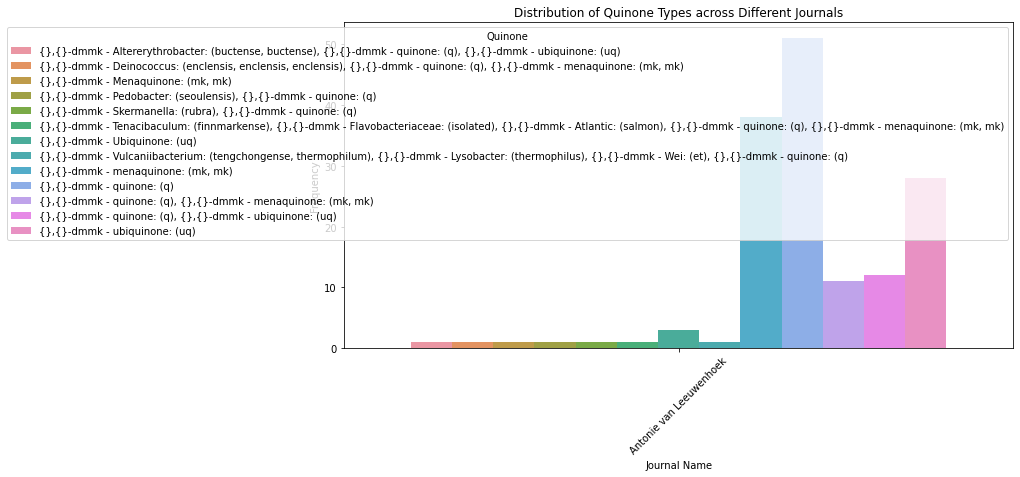

In [22]:
#Bar chart for the distribution of quinone types across different journals
quinone_journal_counts = df.groupby(['Journal Name', 'Quinone']).size().reset_index(name='Count')
plt.figure(figsize=(12, 6))
sns.barplot(x='Journal Name', y='Count', hue='Quinone', data=quinone_journal_counts)
plt.title('Distribution of Quinone Types across Different Journals')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='Quinone', ylabel='Matched Keywords'>

Text(0.5, 1.0, 'Co-occurrence of Matched Keywords and Quinones in the Same Abstracts')

Text(86.99999999999994, 0.5, 'Matched Keywords')

Text(0.5, 33.0, 'Quinone')

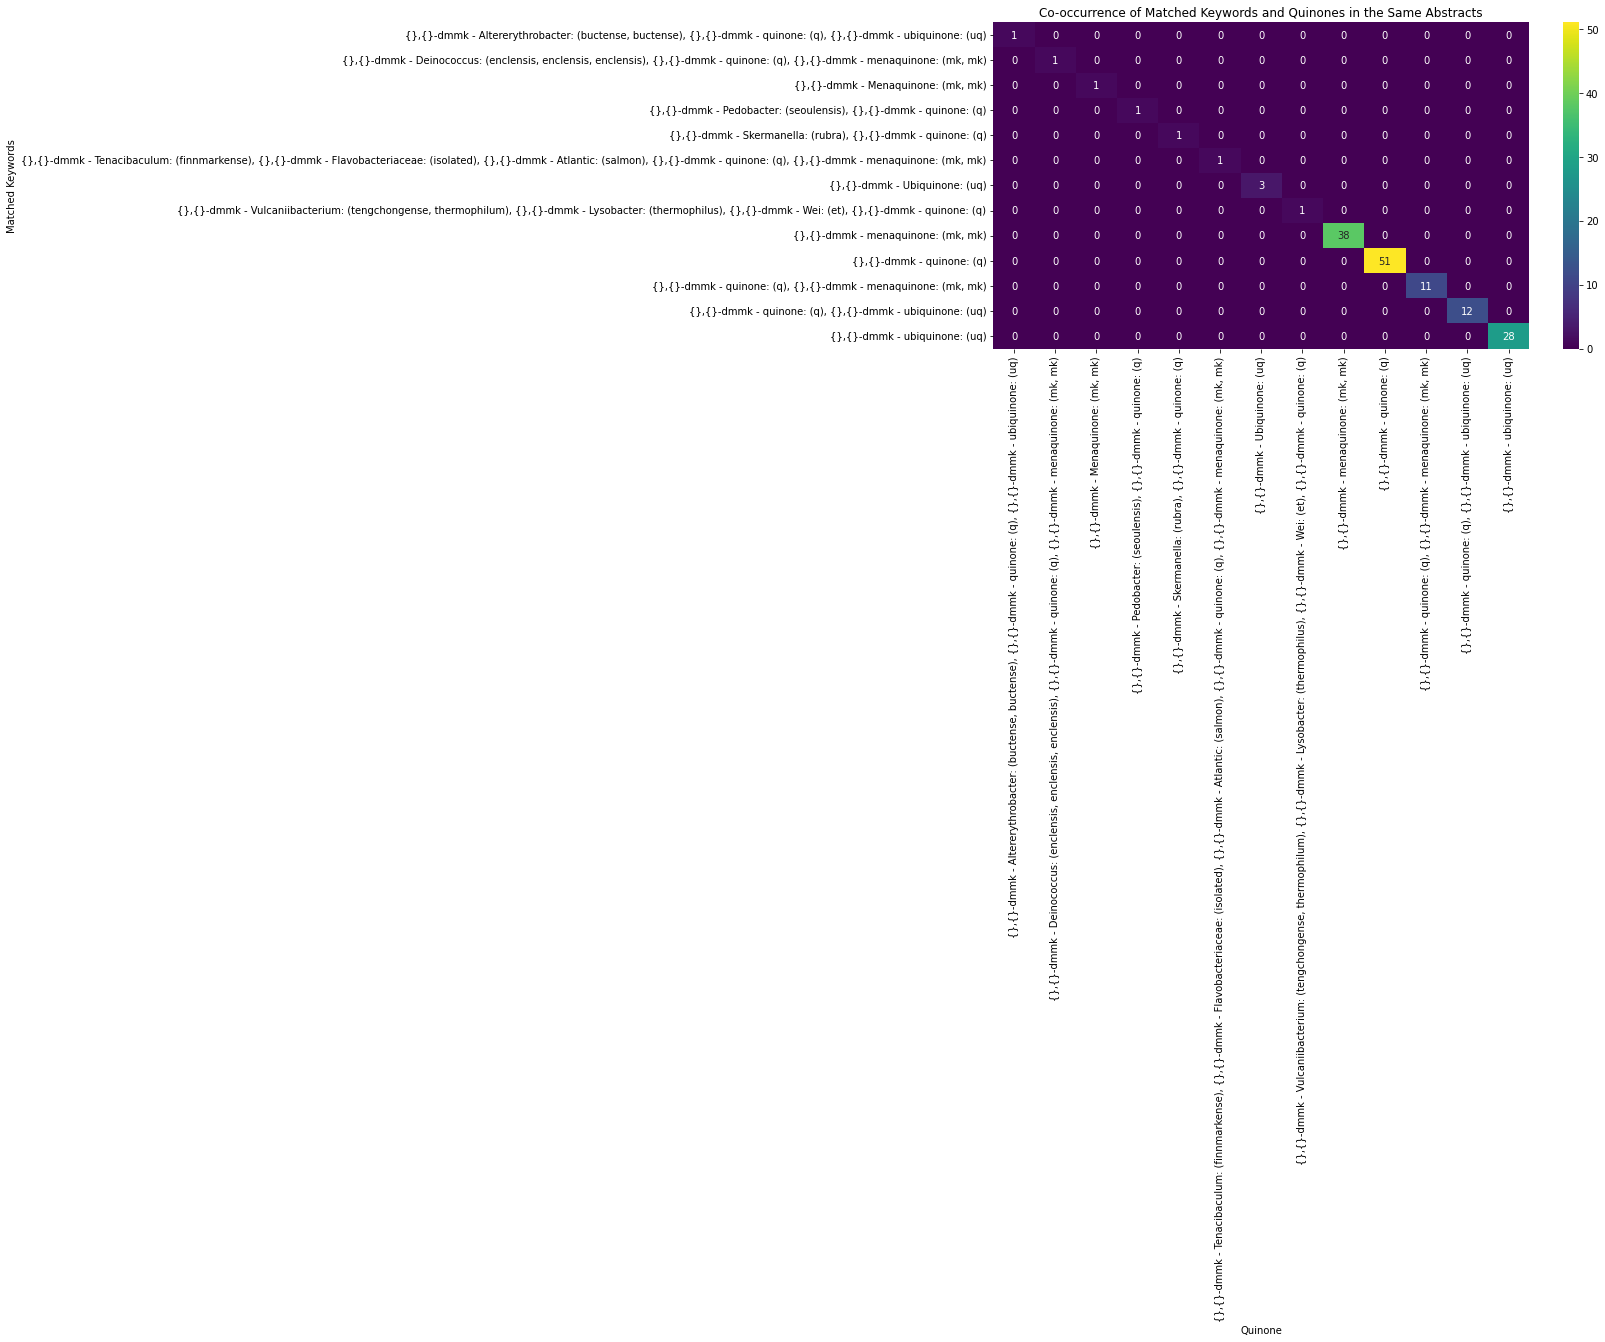

In [26]:
#Heatmap for the co-occurrence of matched keywords and quinones in the same abstracts

co_occurrence_matrix = pd.crosstab(df['Matched Keywords'], df['Quinone'])
plt.figure(figsize=(12, 6))
sns.heatmap(co_occurrence_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Co-occurrence of Matched Keywords and Quinones in the Same Abstracts')
plt.ylabel('Matched Keywords')
plt.xlabel('Quinone')
plt.show()

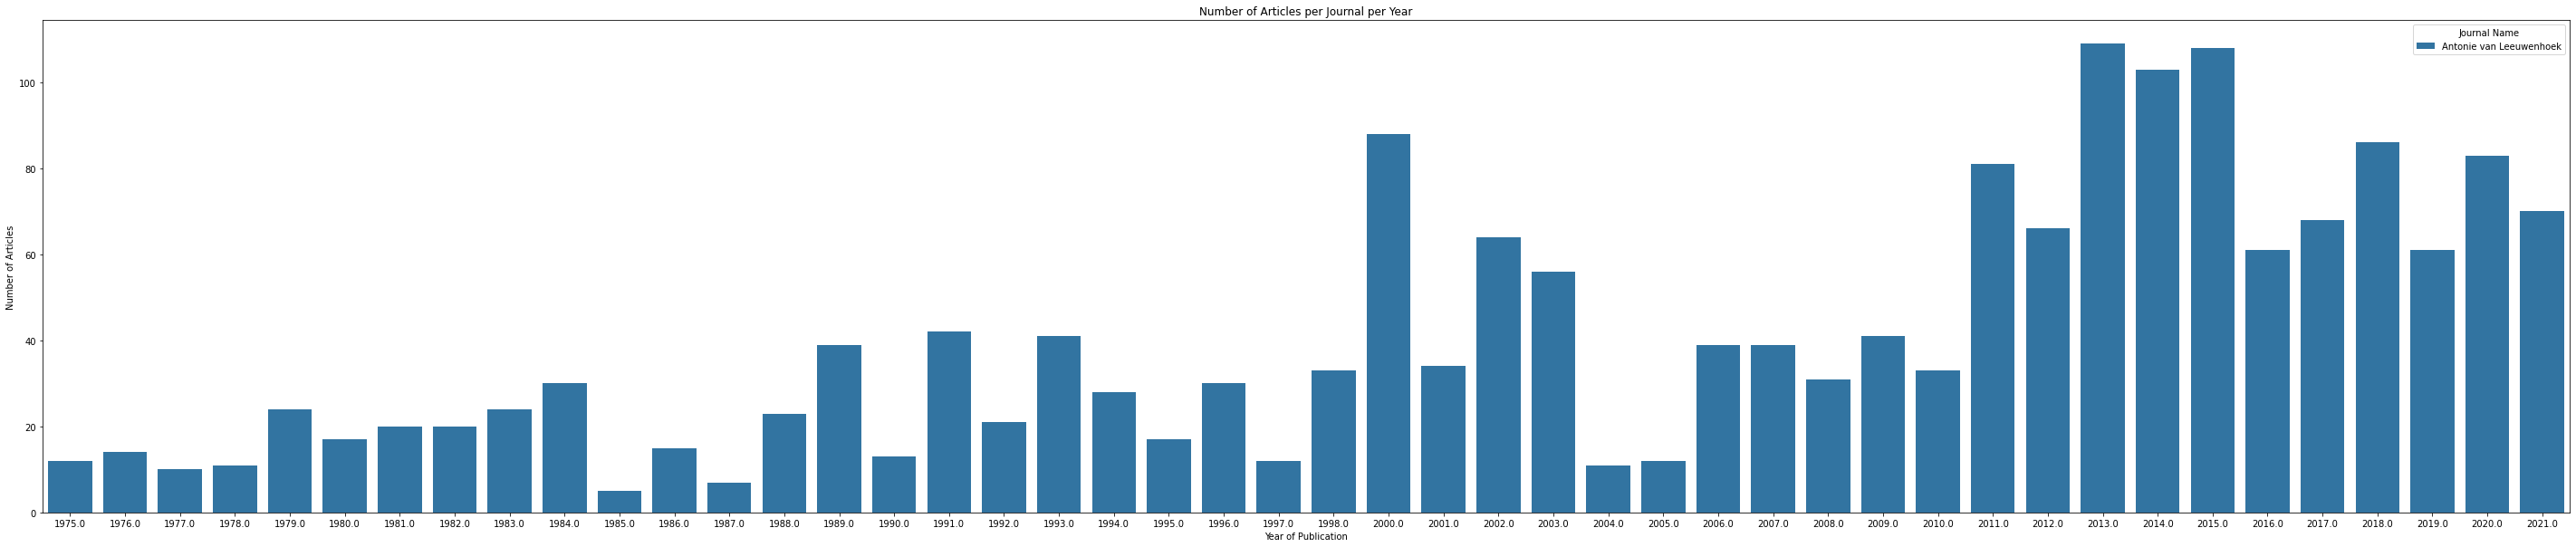

In [5]:
def visualize_data(input_csv="output500.csv"):
    df = pd.read_csv(input_csv)
    df_count = df.groupby(['Journal Name', 'Year of Publication']).size().reset_index(name='Count')

    plt.figure(figsize=(50, 10))
    sns.barplot(data=df_count, x='Year of Publication', y='Count', hue='Journal Name')
    plt.title('Number of Articles per Journal per Year')
    plt.ylabel('Number of Articles')
    plt.xlabel('Year of Publication')
    plt.legend(title='Journal Name')
    plt.show()

visualize_data()


## Computing time for extraction

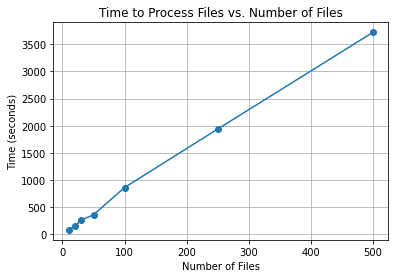

In [33]:
import os
import time
import gzip
from lxml import etree
import matplotlib.pyplot as plt

def visualize_time_to_process(file_limits, path='TIMC-quinoneMining/pubmed-data', journals=['Antonie van Leeuwenhoek', 'Int J Syst Evol Microbiol']):
    processing_times = []

    for file_limit in file_limits:
        start_time = time.time()

        data = []

        xml_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.xml.gz')]

        for i, file_path in enumerate(xml_files):
            if i >= file_limit:
                break
            with gzip.open(file_path, 'rb') as f:
                content = f.read()
                root = etree.fromstring(content)
                for article in root.findall('.//PubmedArticle'):
                    if article.find('.//ArticleTitle') is None:
                        continue
                    if article.find('.//AbstractText') is None:
                        continue
                    journal_name = article.find('.//Journal/Title').text or ''
                    if journal_name not in journals:
                        continue
                    title = article.find('.//ArticleTitle').text or ''
                    abstract = article.find('.//AbstractText').text or ''
                    pubmed_id = article.find('.//PMID').text or ''
                    pub_date = article.find('.//PubDate')
                    if pub_date is not None:
                        pub_year_element = pub_date.find('.//Year')
                        if pub_year_element is not None:
                            pub_year = pub_year_element.text
                        else:
                            pub_year = ''
                    else:
                        pub_year = ''
                    data.append([journal_name, pub_year, pubmed_id, title, abstract])

        processing_times.append(time.time() - start_time)

    plt.plot(file_limits, processing_times, marker='o')
    plt.xlabel('Number of Files')
    plt.ylabel('Time (seconds)')
    plt.title('Time to Process Files vs. Number of Files')
    plt.grid()
    plt.show()

file_limits = [10, 20, 30, 50, 100, 250, 500]
visualize_time_to_process(file_limits)
